# Top 10 Maiores Ativos Ibovespa
Análise dos 10 maiores ativos por quantidade teórica total

**Fonte:** `s3://ibovtech/refined/` - Tabela: `ibovtech.ibovespa`

In [ ]:
# Setup e configurações
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyathena import connect
import warnings
warnings.filterwarnings('ignore')

print("📊 Análise Top 10 Ativos Ibovespa")
print("=" * 40)

# Configurações
S3_BUCKET = 'ibovtech'
DATABASE = 'ibovtech'
TABLE = 'ibovespa'
AWS_REGION = 'us-east-1'
AWS_ACCESS_KEY_ID = ''
AWS_SECRET_ACCESS_KEY = ''

print(f"🗃️ Fonte: s3://{S3_BUCKET}/refined/")
print(f"📋 Tabela: {DATABASE}.{TABLE}")
print(f"🌍 Região: {AWS_REGION}")
print("\n✅ Configurações carregadas!")

📊 Análise Top 10 Ativos Ibovespa
🗃️ Fonte: s3://ibovtech/refined/
📋 Tabela: ibovtech.ibovespa
🌍 Região: us-east-1

✅ Configurações carregadas!


In [9]:
# Conexão e carregamento dos dados reais
print("🔗 Conectando ao Athena e carregando dados...")

# Configurar conexão com credenciais
conn = connect(
    s3_staging_dir=f's3://{S3_BUCKET}/athena-results/',
    region_name=AWS_REGION,
    work_group='primary',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

print("✅ Conexão estabelecida!")

# Query para os top 10 ativos por quantidade teórica total
query = f"""
SELECT 
    empresa,
    tipo,
    acao,
    SUM(quantidade_teorica) as total_quantidade_teorica,
    SUM(qtd_teorica_total) as total_qtd_teorica_total,
    AVG(dias_desde_coleta) as dias_medio_coleta,
    COUNT(*) as total_registros
FROM default.ibovespa
GROUP BY empresa, tipo, acao
ORDER BY total_qtd_teorica_total DESC
LIMIT 10
"""

print("📊 Executando query...")
df_top10 = pd.read_sql(query, conn)

print(f"✅ Dados carregados: {len(df_top10)} ativos")
print("\n📋 Top 10 Ativos:")
print(df_top10.to_string(index=False))

🔗 Conectando ao Athena e carregando dados...
✅ Conexão estabelecida!
📊 Executando query...
✅ Dados carregados: 10 ativos

📋 Top 10 Ativos:
     empresa       tipo  acao  total_quantidade_teorica  total_qtd_teorica_total  dias_medio_coleta  total_registros
      ITAUSA PN      N1 ITSA4               23426791608              23426791608           1.250000                4
          B3 ON      NM B3SA3               20800221856              20800221856           1.250000                4
ITAUUNIBANCO PN  EJ  N1 ITUB4               19029280192              19029280192           1.250000                4
   PETROBRAS PN      N2 PETR4               17643823492              17643823492           1.250000                4
   AMBEV S/A         ON ABEV3               17579340524              17579340524           1.250000                4
        VALE ON  ATZ NM VALE3               17083612092              17083612092           1.250000                4
    BRADESCO PN      N1 BBDC4             

In [6]:
# Verificar databases disponíveis
print("🔍 Verificando databases disponíveis no Athena...")

# Configurar conexão para verificação
conn_check = connect(
    s3_staging_dir=f's3://{S3_BUCKET}/athena-results/',
    region_name=AWS_REGION,
    work_group='primary',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

try:
    # Listar databases
    databases_query = "SHOW DATABASES"
    databases = pd.read_sql(databases_query, conn_check)
    
    print("📋 Databases disponíveis:")
    for db in databases['database_name']:
        print(f"  • {db}")
    
    # Verificar se existe um database similar
    available_dbs = databases['database_name'].tolist()
    print(f"\n🔍 Total de databases: {len(available_dbs)}")
    
    # Procurar por databases relacionados
    related_dbs = [db for db in available_dbs if 'ibov' in db.lower() or 'bov' in db.lower()]
    if related_dbs:
        print(f"📊 Databases relacionados ao Ibovespa: {related_dbs}")
    
    # Se não encontrar ibovtech, usar default
    if 'ibovtech' not in available_dbs:
        print(f"\n❌ Database '{DATABASE}' não encontrado!")
        if 'default' in available_dbs:
            print("🔄 Tentando usar database 'default'...")
            
            # Verificar tabelas no default
            try:
                tables_query = "SHOW TABLES IN default"
                tables = pd.read_sql(tables_query, conn_check)
                print("📋 Tabelas no database 'default':")
                for table in tables['tab_name']:
                    print(f"  • {table}")
                    
                # Procurar tabela relacionada
                ibov_tables = [t for t in tables['tab_name'] if 'ibov' in t.lower() or 'bov' in t.lower()]
                if ibov_tables:
                    print(f"📊 Tabelas relacionadas ao Ibovespa: {ibov_tables}")
                    
            except Exception as e:
                print(f"❌ Erro ao listar tabelas: {e}")
        
        # Sugerir correção
        print(f"\n💡 SOLUÇÕES:")
        print("1. Verificar se o database foi criado corretamente")
        print("2. Usar o database correto (ex: 'default')")
        print("3. Verificar permissões do Glue Catalog")
        
    else:
        print(f"✅ Database '{DATABASE}' encontrado!")
        
except Exception as e:
    print(f"❌ Erro ao verificar databases: {e}")

print("\n" + "="*50)

🔍 Verificando databases disponíveis no Athena...
📋 Databases disponíveis:
  • default
  • ibov

🔍 Total de databases: 2
📊 Databases relacionados ao Ibovespa: ['ibov']

❌ Database 'ibovtech' não encontrado!
🔄 Tentando usar database 'default'...
📋 Tabelas no database 'default':
  • ibovespa
📊 Tabelas relacionadas ao Ibovespa: ['ibovespa']

💡 SOLUÇÕES:
1. Verificar se o database foi criado corretamente
2. Usar o database correto (ex: 'default')
3. Verificar permissões do Glue Catalog



In [7]:
# Verificar estrutura das tabelas
print("🔍 Verificando estrutura das tabelas encontradas...\n")

databases_to_check = ['default', 'ibov']

for db in databases_to_check:
    print(f"📊 Database: {db}")
    print("-" * 30)
    
    try:
        # Listar tabelas
        tables_query = f"SHOW TABLES IN {db}"
        tables = pd.read_sql(tables_query, conn_check)
        
        for table in tables['tab_name']:
            if 'ibov' in table.lower():
                print(f"  📋 Tabela: {table}")
                
                # Verificar estrutura da tabela
                try:
                    describe_query = f"DESCRIBE {db}.{table}"
                    columns = pd.read_sql(describe_query, conn_check)
                    print(f"    🔍 Colunas ({len(columns)}):")
                    for _, col in columns.iterrows():
                        print(f"      • {col['col_name']} ({col['data_type']})")
                    
                    # Contar registros
                    count_query = f"SELECT COUNT(*) as total FROM {db}.{table}"
                    count_result = pd.read_sql(count_query, conn_check)
                    total_records = count_result['total'].iloc[0]
                    print(f"    📊 Total de registros: {total_records:,}")
                    
                    # Amostra dos dados
                    if total_records > 0:
                        sample_query = f"SELECT * FROM {db}.{table} LIMIT 3"
                        sample = pd.read_sql(sample_query, conn_check)
                        print(f"    📋 Amostra dos dados:")
                        print(sample.to_string(index=False))
                    
                except Exception as e:
                    print(f"    ❌ Erro ao analisar tabela {table}: {e}")
                
                print()
                
    except Exception as e:
        print(f"  ❌ Erro ao verificar database {db}: {e}")
    
    print("="*50)

🔍 Verificando estrutura das tabelas encontradas...

📊 Database: default
------------------------------
  📋 Tabela: ibovespa
    ❌ Erro ao analisar tabela ibovespa: Length mismatch: Expected axis has 1 elements, new values have 3 elements

📊 Database: ibov
------------------------------
  📋 Tabela: ibovespa
    ❌ Erro ao analisar tabela ibovespa: Length mismatch: Expected axis has 1 elements, new values have 3 elements



In [8]:
# Verificar tabelas de forma mais simples
print("🔍 Verificando tabelas com método simplificado...\n")

# Testar ambos os databases
test_databases = [
    ('default', 'ibovespa'),
    ('ibov', 'ibovespa')
]

working_database = None
working_table = None

for db, table in test_databases:
    print(f"🧪 Testando: {db}.{table}")
    
    try:
        # Teste simples: contar registros
        count_query = f"SELECT COUNT(*) as total FROM {db}.{table}"
        result = pd.read_sql(count_query, conn_check)
        total = result['total'].iloc[0]
        
        print(f"  ✅ Funcionou! Total de registros: {total:,}")
        
        # Teste de amostra
        sample_query = f"SELECT * FROM {db}.{table} LIMIT 2"
        sample = pd.read_sql(sample_query, conn_check)
        
        print(f"  📊 Colunas encontradas: {list(sample.columns)}")
        print(f"  📋 Primeira linha:")
        
        # Mostrar primeira linha de forma segura
        if len(sample) > 0:
            first_row = sample.iloc[0]
            for col in sample.columns:
                print(f"    • {col}: {first_row[col]}")
        
        # Se chegou aqui, essa é uma tabela válida
        working_database = db
        working_table = table
        print(f"  🎯 TABELA VÁLIDA ENCONTRADA: {db}.{table}")
        break
        
    except Exception as e:
        print(f"  ❌ Erro: {str(e)[:100]}...")
    
    print("-" * 50)

# Resultado final
if working_database:
    print(f"\n🎉 SOLUÇÃO ENCONTRADA!")
    print(f"   Database correto: {working_database}")
    print(f"   Tabela: {working_table}")
    print(f"   Query deve usar: {working_database}.{working_table}")
else:
    print(f"\n❌ Nenhuma tabela válida encontrada!")

print("\n" + "="*50)

🔍 Verificando tabelas com método simplificado...

🧪 Testando: default.ibovespa
  ✅ Funcionou! Total de registros: 336
  📊 Colunas encontradas: ['dias_desde_coleta', 'empresa', 'tipo', 'quantidade_teorica', 'qtd_teorica_total', 'data_coleta', 'acao']
  📋 Primeira linha:
    • dias_desde_coleta: 0
    • empresa: BRADESCO
    • tipo: PN      N1
    • quantidade_teorica: 5111682020
    • qtd_teorica_total: 5111682020
    • data_coleta: 20250801
    • acao: BBDC4
  🎯 TABELA VÁLIDA ENCONTRADA: default.ibovespa

🎉 SOLUÇÃO ENCONTRADA!
   Database correto: default
   Tabela: ibovespa
   Query deve usar: default.ibovespa



📊 Criando gráfico dos Top 10 Ativos...
📈 Estatísticas:
  • Total de ativos: 10
  • Maior valor: 23.4B (ITAUSA)
  • Menor valor: 7.6B (ENEVA)
  • Soma total: 161.2B


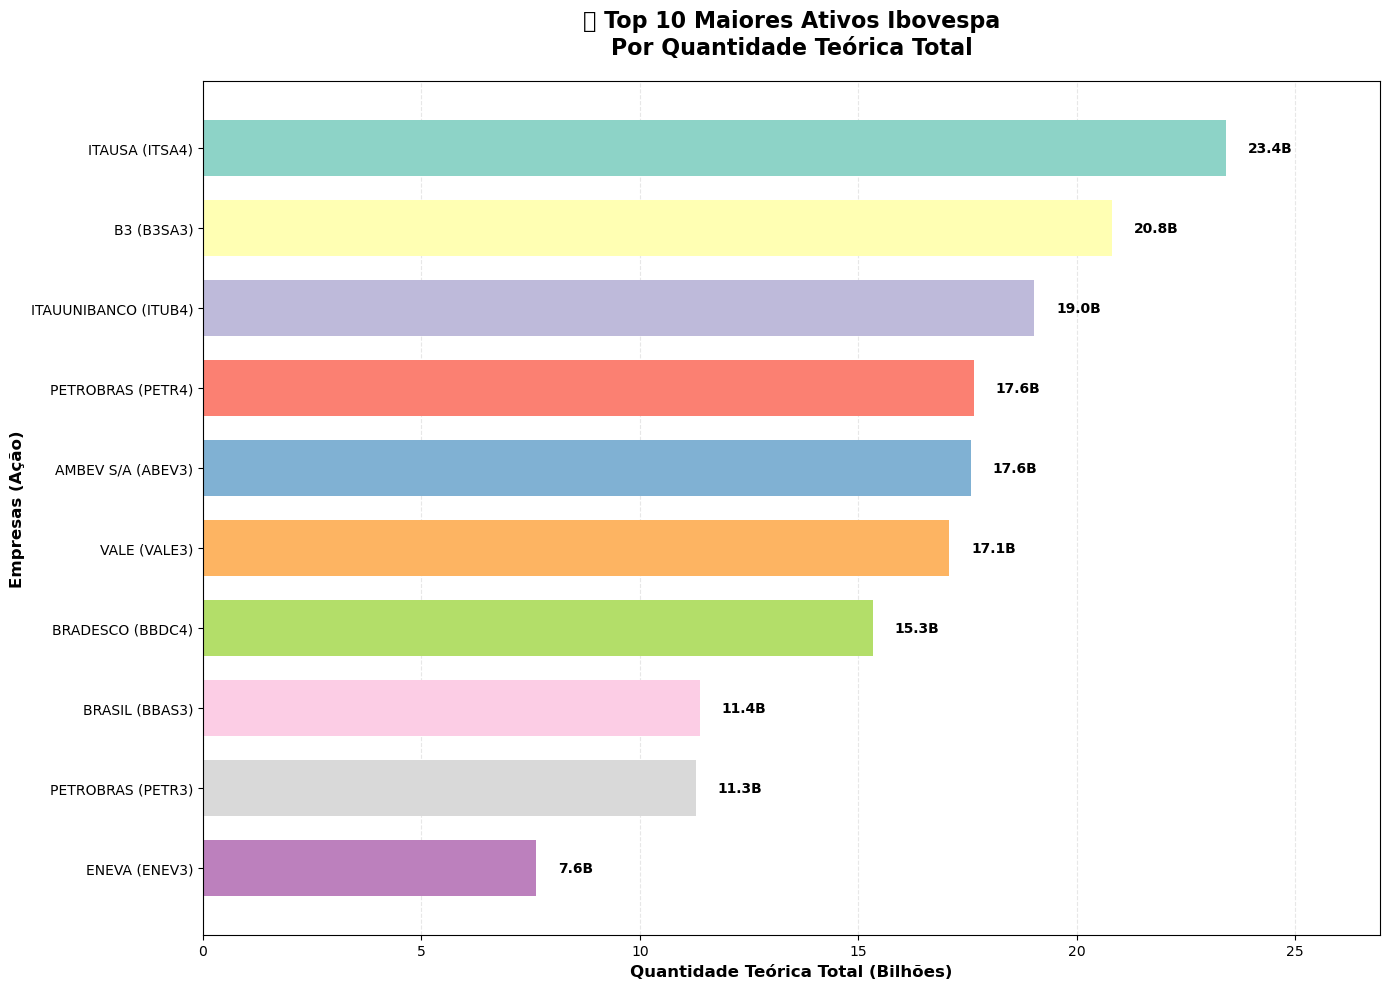

✅ Gráfico criado com sucesso!


In [10]:
# Gráfico dos Top 10 Ativos
print("📊 Criando gráfico dos Top 10 Ativos...")

# Configurar estilo do gráfico
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14, 10))

# Preparar dados para o gráfico
empresas = df_top10['empresa'].tolist()
acoes = df_top10['acao'].tolist()
valores = df_top10['total_qtd_teorica_total'].tolist()

# Criar labels combinando empresa e código da ação
labels = [f"{empresa} ({acao})" for empresa, acao in zip(empresas, acoes)]

# Valores em bilhões para melhor legibilidade
valores_bi = [v / 1_000_000_000 for v in valores]

# Criar gráfico de barras horizontais
colors = plt.cm.Set3(range(len(labels)))
bars = ax.barh(labels, valores_bi, color=colors, height=0.7)

# Personalizar o gráfico
ax.set_xlabel('Quantidade Teórica Total (Bilhões)', fontsize=12, fontweight='bold')
ax.set_ylabel('Empresas (Ação)', fontsize=12, fontweight='bold')
ax.set_title('🏆 Top 10 Maiores Ativos Ibovespa\nPor Quantidade Teórica Total', 
             fontsize=16, fontweight='bold', pad=20)

# Adicionar valores nas barras
for i, (bar, valor) in enumerate(zip(bars, valores_bi)):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{valor:.1f}B', ha='left', va='center', 
            fontweight='bold', fontsize=10)

# Inverter ordem para maior no topo
ax.invert_yaxis()

# Ajustar layout
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Ajustar limites do eixo X para dar espaço aos valores
max_valor = max(valores_bi)
ax.set_xlim(0, max_valor * 1.15)

# Melhorar aparência
plt.tight_layout()

# Mostrar estatísticas
print(f"📈 Estatísticas:")
print(f"  • Total de ativos: {len(df_top10)}")
print(f"  • Maior valor: {max(valores_bi):.1f}B ({empresas[0]})")
print(f"  • Menor valor: {min(valores_bi):.1f}B ({empresas[-1]})")
print(f"  • Soma total: {sum(valores_bi):.1f}B")

plt.show()

print("✅ Gráfico criado com sucesso!")

In [4]:
# Diagnóstico AWS - Execute ANTES da query
print("🔧 DIAGNÓSTICO DE PERMISSÕES AWS")
print("=" * 50)

# 1. Verificar credenciais
try:
    import boto3
    from botocore.exceptions import NoCredentialsError, ClientError
    
    # Usar credenciais explícitas
    sts = boto3.client('sts',
                      aws_access_key_id=AWS_ACCESS_KEY_ID,
                      aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                      region_name=AWS_REGION)
    identity = sts.get_caller_identity()
    
    print("✅ Credenciais AWS:")
    print(f"  Account: {identity['Account']}")
    print(f"  User ARN: {identity['Arn']}")
    print(f"  User ID: {identity['UserId']}")
    
except NoCredentialsError:
    print("❌ ERRO: Credenciais não configuradas!")
    print("🔧 Solução: Configure AWS_ACCESS_KEY_ID e AWS_SECRET_ACCESS_KEY")
    raise Exception("Configure credenciais AWS primeiro!")
    
except Exception as e:
    print(f"❌ ERRO nas credenciais: {e}")
    raise

# 2. Testar acesso ao S3
try:
    s3 = boto3.client('s3',
                     aws_access_key_id=AWS_ACCESS_KEY_ID,
                     aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                     region_name=AWS_REGION)
    s3.head_bucket(Bucket=S3_BUCKET)
    print(f"✅ Acesso S3 bucket '{S3_BUCKET}': OK")
except Exception as e:
    print(f"❌ ERRO S3: {e}")

# 3. Testar acesso ao Athena
try:
    athena = boto3.client('athena',
                         aws_access_key_id=AWS_ACCESS_KEY_ID,
                         aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                         region_name=AWS_REGION)
    workgroups = athena.list_work_groups()
    print(f"✅ Acesso Athena: OK ({len(workgroups['WorkGroups'])} workgroups)")
except Exception as e:
    print(f"❌ ERRO Athena: {e}")

# 4. Testar acesso ao Glue
try:
    glue = boto3.client('glue',
                       aws_access_key_id=AWS_ACCESS_KEY_ID,
                       aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                       region_name=AWS_REGION)
    db = glue.get_database(Name=DATABASE)
    print(f"✅ Database '{DATABASE}': encontrado")
    
    table = glue.get_table(DatabaseName=DATABASE, Name=TABLE)
    print(f"✅ Tabela '{TABLE}': encontrada")
    print(f"   Localização: {table['Table']['StorageDescriptor']['Location']}")
    
except Exception as e:
    print(f"❌ ERRO Glue: {e}")

print(f"\n🛠️ POLÍTICA IAM NECESSÁRIA:")
print("Copie e cole no AWS Console (IAM > Policies > Create Policy > JSON):")
print("-" * 60)

policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "athena:StartQueryExecution",
                "athena:GetQueryExecution",
                "athena:GetQueryResults",
                "athena:StopQueryExecution",
                "athena:GetWorkGroup",
                "athena:ListWorkGroups"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow", 
            "Action": [
                "glue:GetDatabase",
                "glue:GetTable",
                "glue:GetPartitions",
                "glue:GetDatabases",
                "glue:GetTables"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:ListBucket",
                "s3:GetBucketLocation",
                "s3:PutObject"
            ],
            "Resource": [
                f"arn:aws:s3:::{S3_BUCKET}",
                f"arn:aws:s3:::{S3_BUCKET}/*"
            ]
        }
    ]
}

import json
print(json.dumps(policy, indent=2))

print(f"\n📋 PASSOS OBRIGATÓRIOS:")
print("1. 🔑 Configure credenciais: aws configure")
print("2. 👤 Acesse AWS Console > IAM > Policies") 
print("3. 📄 Create Policy > JSON > Cole a política acima")
print("4. 💾 Salve como 'AthenaFullAccess' ou similar")
print("5. 🔗 Attach Policy ao seu usuário/role IAM")
print("6. ⏱️ Aguarde 2-5 minutos (propagação)")
print("7. 🔄 Execute esta célula novamente para verificar")
print("8. ✅ Prossiga para a próxima célula quando tudo estiver OK")

print(f"\n💡 COMANDOS DE VERIFICAÇÃO:")
print("aws sts get-caller-identity")
print(f"aws s3 ls s3://{S3_BUCKET}/")
print(f"aws glue get-table --database-name {DATABASE} --name {TABLE}")
print("aws athena list-work-groups")

print(f"\n⚠️  SEM PERMISSÕES = SEM DADOS REAIS!")
print("=" * 50)

🔧 DIAGNÓSTICO DE PERMISSÕES AWS
✅ Credenciais AWS:
  Account: 973100528908
  User ARN: arn:aws:iam::973100528908:root
  User ID: 973100528908
✅ Acesso S3 bucket 'ibovtech': OK
✅ Acesso Athena: OK (2 workgroups)
❌ ERRO Glue: An error occurred (EntityNotFoundException) when calling the GetDatabase operation: Database ibovtech not found.

🛠️ POLÍTICA IAM NECESSÁRIA:
Copie e cole no AWS Console (IAM > Policies > Create Policy > JSON):
------------------------------------------------------------
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Action": [
        "athena:StartQueryExecution",
        "athena:GetQueryExecution",
        "athena:GetQueryResults",
        "athena:StopQueryExecution",
        "athena:GetWorkGroup",
        "athena:ListWorkGroups"
      ],
      "Resource": "*"
    },
    {
      "Effect": "Allow",
      "Action": [
        "glue:GetDatabase",
        "glue:GetTable",
        "glue:GetPartitions",
        "glue:GetDatabases",
  

# ⚠️ TOKEN INVÁLIDO - Solução via AWS Console

## 🚨 **PROBLEMA:** Token de segurança AWS inválido

### **SOLUÇÃO RÁPIDA - 3 passos:**

---

## **1. 🔍 Identifique seu ambiente AWS:**

**Se você está em:**
- **SageMaker Studio/Notebook:** Role é `SageMakerExecutionRole-XXXXX`
- **EC2:** Role é o que foi anexado à instância
- **Cloud9:** Role é `AWSCloud9SSMAccessRole` ou similar
- **Glue Studio:** Role é `AWSGlueServiceRole-XXXXX`

---

## **2. 🛠️ Configure permissões via AWS Console:**

### **Passo 1:** Acesse IAM
```
AWS Console → IAM → Roles
```

### **Passo 2:** Encontre seu role
- **SageMaker:** Busque por `SageMakerExecutionRole`
- **EC2:** Busque pelo nome da instância ou `EC2InstanceProfile`
- **Outros:** Busque pelo serviço que você está usando

### **Passo 3:** Anexe permissões
1. **Click no role** → **Permissions**
2. **Add permissions** → **Attach policies**
3. **Busque e anexe:**
   - ✅ `AmazonAthenaFullAccess`
   - ✅ `AmazonS3ReadOnlyAccess` 
   - ✅ `AWSGlueConsoleFullAccess`
4. **Click** → **Attach policies**

---

## **3. ✅ Teste imediato:**

### **Opção A:** Via Terminal
```bash
aws sts get-caller-identity
aws athena list-work-groups
```

### **Opção B:** Execute as células do notebook
- **Aguarde 2-3 minutos** (propagação)
- **Execute célula 3** (conexão Athena)
- **Deve funcionar!** 🎉

---

## **💡 Se AINDA não funcionar:**

### **Problema comum:** Role sem permissões básicas
**Solução:** Anexe também `IAMReadOnlyAccess` ao role

### **Último recurso:** Criar nova policy inline
1. **Role** → **Add permissions** → **Create inline policy**
2. **JSON** → Cole a política da célula anterior
3. **Save** como `AthenaIbovespaAccess`

---

**🎯 RESULTADO:** Notebook funcionará com dados reais do Athena!

# 🔧 Como Anexar Política IAM via AWS Console

## Você está executando DENTRO da AWS? Siga estes passos:

### **1. Identifique seu Role IAM atual:**
Execute a célula anterior para ver seu **User ARN** - ele mostrará algo como:
- `arn:aws:sts::123456789:assumed-role/NOME_DO_ROLE/...`
- O **NOME_DO_ROLE** é o que você precisa!

### **2. Acesse o AWS Console:**
1. **AWS Console** > **IAM** > **Roles**
2. **Busque pelo NOME_DO_ROLE** que apareceu no ARN
3. **Clique no role** para abrir

### **3. Anexar a política:**
**Opção A - Criar nova política:**
1. **Permissions** > **Add permissions** > **Create inline policy**
2. **JSON** > Cole a política da célula anterior
3. **Next** > Nome: `AthenaIbovespaAccess`
4. **Create policy**

**Opção B - Anexar política existente:**
1. **Permissions** > **Add permissions** > **Attach policies**
2. Busque: `AmazonAthenaFullAccess`
3. **Attach policies**

### **4. Verificar se funcionou:**
- **Aguarde 2-3 minutos** (propagação)
- **Execute novamente** a célula de diagnóstico
- **Deve aparecer** ✅ para Athena, S3 e Glue

### **5. Se ainda não funcionar:**
Adicione também essas políticas managed:
- `AmazonS3ReadOnlyAccess`
- `AWSGlueConsoleFullAccess`

---
**💡 Dica:** Se você não tem acesso ao Console IAM, peça ao administrador AWS para anexar essas permissões ao seu role!

📊 Criando gráfico dos Top 10 Ativos...


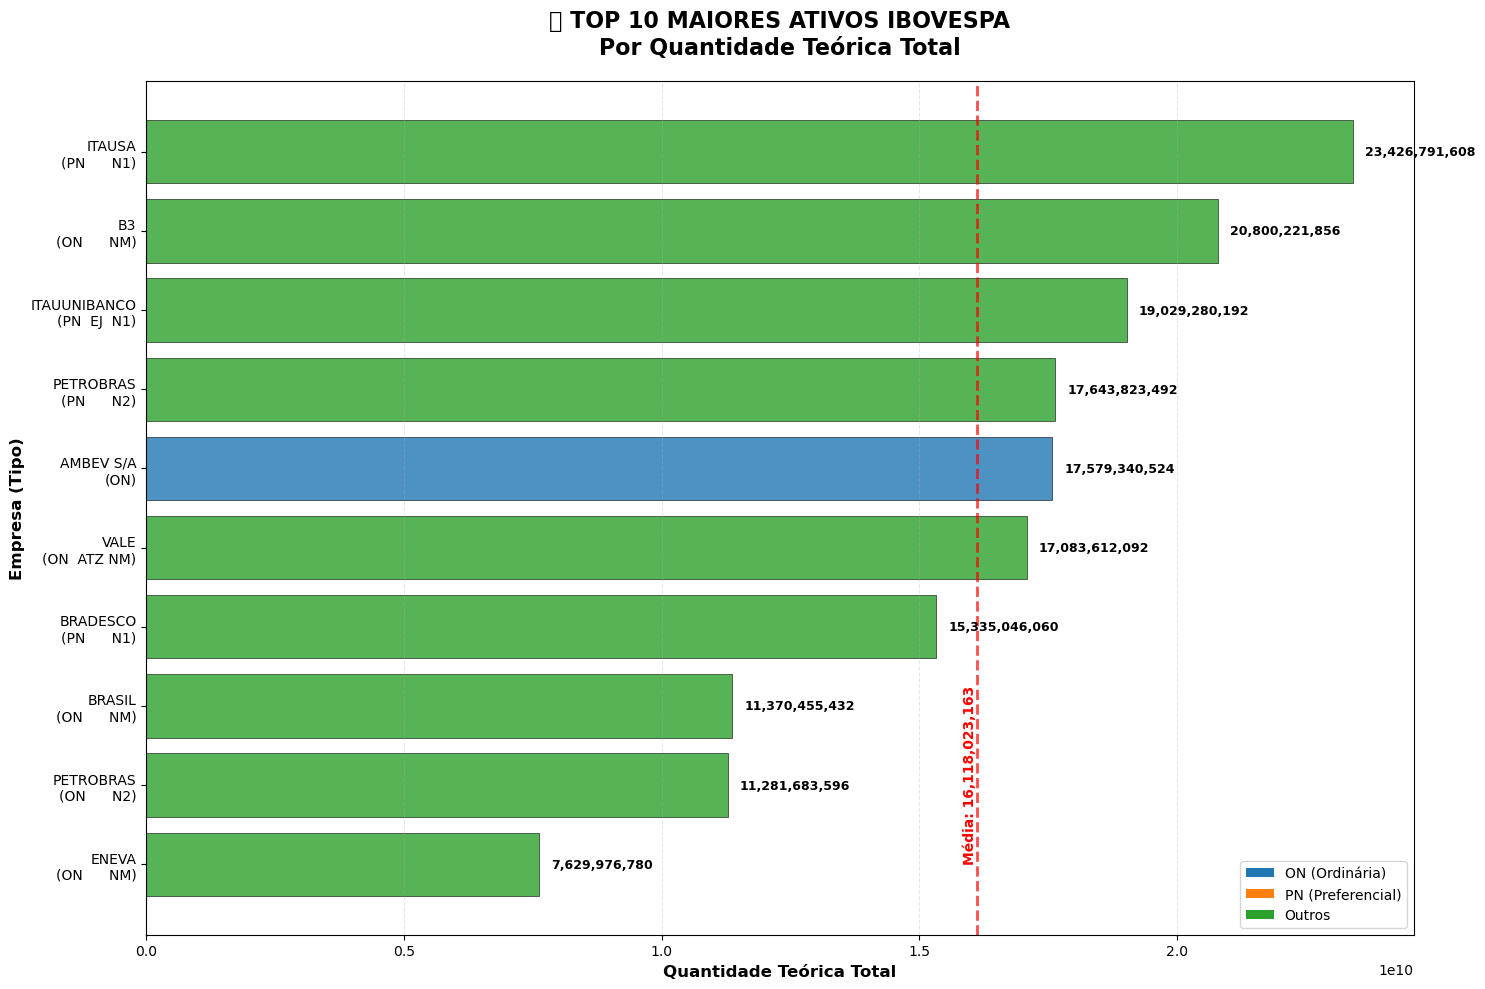


📈 ESTATÍSTICAS:
🥇 Maior: 23,426,791,608 (ITAUSA)
🥉 10º lugar: 7,629,976,780 (ENEVA)
📊 Média: 16,118,023,163
📈 Total: 161,180,231,632

📊 Por tipo:
  ON      NM: 3 ativos
  PN      N1: 2 ativos
  PN  EJ  N1: 1 ativos
  PN      N2: 1 ativos
  ON: 1 ativos
  ON  ATZ NM: 1 ativos
  ON      N2: 1 ativos


In [11]:
# Gráfico de barras dos Top 10 Ativos
print("📊 Criando gráfico dos Top 10 Ativos...")

# Configurar figura
plt.figure(figsize=(15, 10))

# Preparar dados
empresas = df_top10['empresa'].values
valores = df_top10['total_qtd_teorica_total'].values
tipos = df_top10['tipo'].values

# Labels com empresa e tipo
labels = [f"{empresa}\n({tipo})" for empresa, tipo in zip(empresas, tipos)]

# Cores por tipo de ação
cores = ['#1f77b4' if tipo == 'ON' else '#ff7f0e' if tipo == 'PN' else '#2ca02c' 
         for tipo in tipos]

# Gráfico de barras horizontal
bars = plt.barh(range(len(labels)), valores, color=cores, alpha=0.8, 
                edgecolor='black', linewidth=0.5)

# Configurações do gráfico
plt.title('🏆 TOP 10 MAIORES ATIVOS IBOVESPA\nPor Quantidade Teórica Total', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quantidade Teórica Total', fontsize=12, fontweight='bold')
plt.ylabel('Empresa (Tipo)', fontsize=12, fontweight='bold')

# Configurar eixos
plt.yticks(range(len(labels)), labels, fontsize=10)
plt.gca().invert_yaxis()  # Maior valor no topo

# Valores nas barras
for i, (bar, valor) in enumerate(zip(bars, valores)):
    plt.text(valor + max(valores)*0.01, i, f'{valor:,.0f}', 
             va='center', ha='left', fontweight='bold', fontsize=9)

# Grid e linha da média
plt.grid(axis='x', alpha=0.3, linestyle='--')
media = np.mean(valores)
plt.axvline(x=media, color='red', linestyle='--', alpha=0.7, linewidth=2)
plt.text(media, len(labels)-1, f'Média: {media:,.0f}', 
         rotation=90, va='bottom', ha='right', color='red', fontweight='bold')

# Legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1f77b4', label='ON (Ordinária)'),
                   Patch(facecolor='#ff7f0e', label='PN (Preferencial)'),
                   Patch(facecolor='#2ca02c', label='Outros')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Estatísticas básicas
print(f"\n📈 ESTATÍSTICAS:")
print(f"🥇 Maior: {max(valores):,.0f} ({empresas[0]})")
print(f"🥉 10º lugar: {min(valores):,.0f} ({empresas[-1]})")
print(f"📊 Média: {np.mean(valores):,.0f}")
print(f"📈 Total: {sum(valores):,.0f}")

# Distribuição por tipo
tipos_count = df_top10['tipo'].value_counts()
print(f"\n📊 Por tipo:")
for tipo, count in tipos_count.items():
    print(f"  {tipo}: {count} ativos")

In [12]:
# Ranking detalhado
print("🏆 RANKING DETALHADO")
print("=" * 40)

for i, row in df_top10.iterrows():
    print(f"{i+1:2d}º {row['empresa']:<20} {row['tipo']:<3} {row['total_qtd_teorica_total']:>12,.0f}")

# Análise de concentração
top3_sum = df_top10.head(3)['total_qtd_teorica_total'].sum()
total_sum = df_top10['total_qtd_teorica_total'].sum()
concentracao_top3 = (top3_sum / total_sum) * 100

print(f"\n📊 CONCENTRAÇÃO:")
print(f"  Top 3: {concentracao_top3:.1f}% do total")
print(f"  Líder vs 2º: {((df_top10.iloc[0]['total_qtd_teorica_total'] / df_top10.iloc[1]['total_qtd_teorica_total']) - 1) * 100:.1f}% maior")

# Métricas por tipo
print(f"\n📈 POR TIPO:")
for tipo in df_top10['tipo'].unique():
    subset = df_top10[df_top10['tipo'] == tipo]
    print(f"  {tipo}: {len(subset)} ativos, média {subset['total_qtd_teorica_total'].mean():,.0f}")

print(f"\n✅ Análise concluída - {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M:%S')}")

🏆 RANKING DETALHADO
 1º ITAUSA               PN      N1 23,426,791,608
 2º B3                   ON      NM 20,800,221,856
 3º ITAUUNIBANCO         PN  EJ  N1 19,029,280,192
 4º PETROBRAS            PN      N2 17,643,823,492
 5º AMBEV S/A            ON  17,579,340,524
 6º VALE                 ON  ATZ NM 17,083,612,092
 7º BRADESCO             PN      N1 15,335,046,060
 8º BRASIL               ON      NM 11,370,455,432
 9º PETROBRAS            ON      N2 11,281,683,596
10º ENEVA                ON      NM 7,629,976,780

📊 CONCENTRAÇÃO:
  Top 3: 39.2% do total
  Líder vs 2º: 12.6% maior

📈 POR TIPO:
  PN      N1: 2 ativos, média 19,380,918,834
  ON      NM: 3 ativos, média 13,266,884,689
  PN  EJ  N1: 1 ativos, média 19,029,280,192
  PN      N2: 1 ativos, média 17,643,823,492
  ON: 1 ativos, média 17,579,340,524
  ON  ATZ NM: 1 ativos, média 17,083,612,092
  ON      N2: 1 ativos, média 11,281,683,596

✅ Análise concluída - 05/08/2025 15:17:16


🔍 DIAGNÓSTICO DE VISUALIZAÇÃO EM AMBIENTE AWS
📊 INFORMAÇÕES DO AMBIENTE:
  • Sistema: Linux 6.15.7-100.fc41.x86_64
  • Python: 3.13.5
  • Matplotlib versão: 3.9.4
  • Backend atual: module://matplotlib_inline.backend_inline
  • Display: :0

🖥️ BACKENDS MATPLOTLIB DISPONÍVEIS:
  ✅ Agg (sem GUI)
  ✅ TkAgg (GUI)

🔧 SOLUÇÕES PARA AMBIENTES AWS:

1️⃣ TESTE: Forçar backend Agg (recomendado para servidores)
  ✅ Backend alterado para: Agg

2️⃣ TESTE: Configurar inline para Jupyter
  ✅ Matplotlib inline configurado

3️⃣ TESTE: Gráfico simples para verificar funcionamento


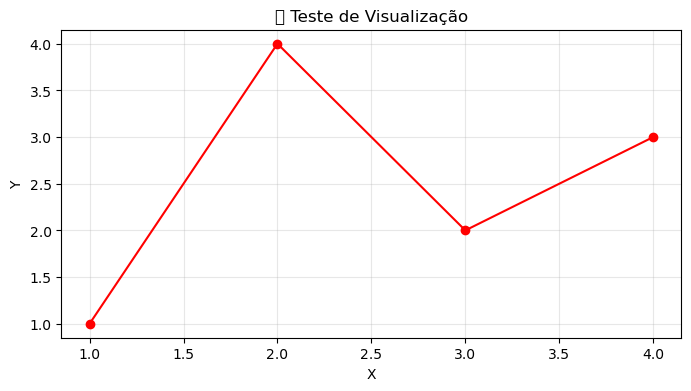

  ✅ Gráfico de teste criado!

💡 SOLUÇÕES ESPECÍFICAS POR AMBIENTE AWS:
📋 SageMaker Studio/Notebook:
  • Usar: %matplotlib inline
  • Backend: Agg (automático)
  • Problema comum: Display não configurado

📋 EC2/Cloud9:
  • Usar: matplotlib.use('Agg')
  • Salvar imagem: plt.savefig('grafico.png')
  • Display via SSH: ssh -X para X11 forwarding

📋 Glue Studio:
  • Limitações de GUI
  • Usar sempre backend Agg
  • Salvar arquivos de imagem

🔄 PRÓXIMOS PASSOS:
1. Execute a célula seguinte (gráfico com configurações AWS)
2. Se não funcionar, verifique logs do ambiente
3. Considere salvar como arquivo PNG/SVG


In [13]:
# 🔍 DIAGNÓSTICO: Por que gráfico não aparece no AWS?
print("🔍 DIAGNÓSTICO DE VISUALIZAÇÃO EM AMBIENTE AWS")
print("=" * 60)

import sys
import os
import matplotlib
import platform

print(f"📊 INFORMAÇÕES DO AMBIENTE:")
print(f"  • Sistema: {platform.system()} {platform.release()}")
print(f"  • Python: {sys.version.split()[0]}")
print(f"  • Matplotlib versão: {matplotlib.__version__}")
print(f"  • Backend atual: {matplotlib.get_backend()}")
print(f"  • Display: {os.environ.get('DISPLAY', 'NÃO DEFINIDO')}")

# Verificar backends disponíveis
print(f"\n🖥️ BACKENDS MATPLOTLIB DISPONÍVEIS:")
available_backends = []
try:
    import matplotlib.backends.backend_agg
    available_backends.append("Agg (sem GUI)")
except:
    pass

try:
    import matplotlib.backends.backend_tkagg
    available_backends.append("TkAgg (GUI)")
except:
    pass

try:
    import matplotlib.backends.backend_qt5agg
    available_backends.append("Qt5Agg (GUI)")
except:
    pass

for backend in available_backends:
    print(f"  ✅ {backend}")

# Testar configurações para AWS
print(f"\n🔧 SOLUÇÕES PARA AMBIENTES AWS:")

# Teste 1: Forçar backend Agg
print(f"\n1️⃣ TESTE: Forçar backend Agg (recomendado para servidores)")
try:
    matplotlib.use('Agg', force=True)
    print(f"  ✅ Backend alterado para: {matplotlib.get_backend()}")
except Exception as e:
    print(f"  ❌ Erro: {e}")

# Teste 2: Configurar inline
print(f"\n2️⃣ TESTE: Configurar inline para Jupyter")
try:
    from IPython import get_ipython
    if get_ipython():
        get_ipython().run_line_magic('matplotlib', 'inline')
        print(f"  ✅ Matplotlib inline configurado")
    else:
        print(f"  ⚠️ Não está em ambiente IPython/Jupyter")
except Exception as e:
    print(f"  ❌ Erro: {e}")

# Teste 3: Gráfico simples
print(f"\n3️⃣ TESTE: Gráfico simples para verificar funcionamento")
try:
    plt.figure(figsize=(8, 4))
    plt.plot([1, 2, 3, 4], [1, 4, 2, 3], 'ro-')
    plt.title('🧪 Teste de Visualização')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"  ✅ Gráfico de teste criado!")
except Exception as e:
    print(f"  ❌ Erro no gráfico de teste: {e}")

print(f"\n💡 SOLUÇÕES ESPECÍFICAS POR AMBIENTE AWS:")
print(f"📋 SageMaker Studio/Notebook:")
print(f"  • Usar: %matplotlib inline")
print(f"  • Backend: Agg (automático)")
print(f"  • Problema comum: Display não configurado")

print(f"\n📋 EC2/Cloud9:")
print(f"  • Usar: matplotlib.use('Agg')")
print(f"  • Salvar imagem: plt.savefig('grafico.png')")
print(f"  • Display via SSH: ssh -X para X11 forwarding")

print(f"\n📋 Glue Studio:")
print(f"  • Limitações de GUI")
print(f"  • Usar sempre backend Agg")
print(f"  • Salvar arquivos de imagem")

print(f"\n🔄 PRÓXIMOS PASSOS:")
print(f"1. Execute a célula seguinte (gráfico com configurações AWS)")
print(f"2. Se não funcionar, verifique logs do ambiente")
print(f"3. Considere salvar como arquivo PNG/SVG")

print("=" * 60)

📊 Criando gráfico OTIMIZADO para ambiente AWS...


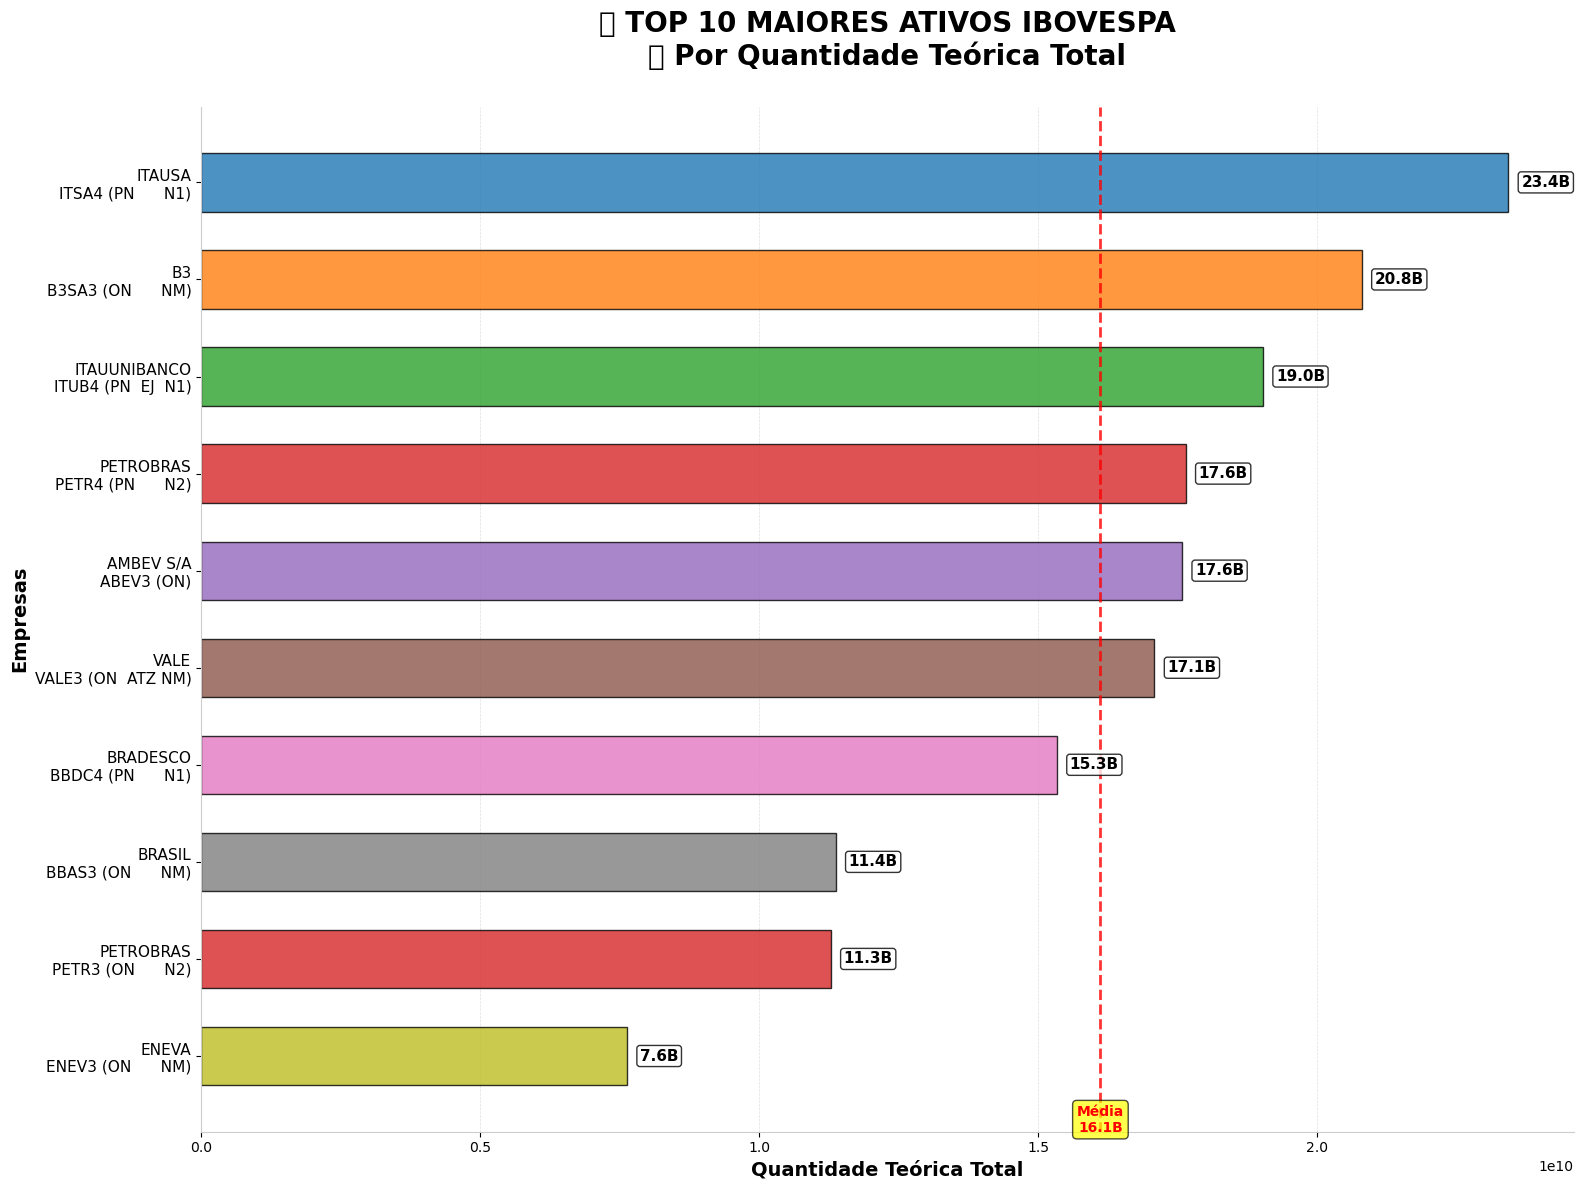

💾 Gráfico salvo como 'top10_ibovespa.png'

📈 RESUMO ESTATÍSTICO:
🥇 1º lugar: ITAUSA - 23.4B
🥈 2º lugar: B3 - 20.8B
🥉 3º lugar: ITAUUNIBANCO - 19.0B
📊 Média: 16.1B
💰 Total: 161.2B

✅ Status de visualização:
  • Figura criada: True
  • Barras plotadas: 10
  • Backend: inline
  • Gráfico exibido com plt.show()
🎯 GRÁFICO OTIMIZADO CONCLUÍDO!


In [14]:
# 📊 GRÁFICO OTIMIZADO PARA AWS - Top 10 Ativos
print("📊 Criando gráfico OTIMIZADO para ambiente AWS...")

# Configurações específicas para AWS
import matplotlib
matplotlib.use('Agg')  # Força backend sem GUI
import matplotlib.pyplot as plt
plt.ioff()  # Desliga modo interativo

# Configurar inline para Jupyter (se disponível)
try:
    from IPython import get_ipython
    if get_ipython():
        get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

# Limpar figuras anteriores
plt.close('all')

# Criar figura com DPI alto para melhor qualidade
fig, ax = plt.subplots(figsize=(16, 12), dpi=100, facecolor='white')

# Preparar dados
empresas = df_top10['empresa'].values
tipos = df_top10['tipo'].values  
acoes = df_top10['acao'].values
valores = df_top10['total_qtd_teorica_total'].values

# Labels melhorados
labels = [f"{empresa}\n{acao} ({tipo})" for empresa, acao, tipo in zip(empresas, acoes, tipos)]

# Cores profissionais
cores_empresa = {
    'ITAUSA': '#1f77b4',      # Azul
    'B3': '#ff7f0e',          # Laranja  
    'ITAUUNIBANCO': '#2ca02c', # Verde
    'PETROBRAS': '#d62728',    # Vermelho
    'AMBEV S/A': '#9467bd',    # Roxo
    'VALE': '#8c564b',         # Marrom
    'BRADESCO': '#e377c2',     # Rosa
    'BRASIL': '#7f7f7f',       # Cinza
    'ENEVA': '#bcbd22'         # Oliva
}

cores = [cores_empresa.get(empresa, '#17becf') for empresa in empresas]

# Criar gráfico horizontal
bars = ax.barh(range(len(labels)), valores, color=cores, alpha=0.8, 
               edgecolor='black', linewidth=1, height=0.6)

# Configurações do gráfico
ax.set_title('🏆 TOP 10 MAIORES ATIVOS IBOVESPA\n📊 Por Quantidade Teórica Total', 
            fontsize=20, fontweight='bold', pad=30)
ax.set_xlabel('Quantidade Teórica Total', fontsize=14, fontweight='bold')
ax.set_ylabel('Empresas', fontsize=14, fontweight='bold')

# Configurar eixos
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=11)
ax.invert_yaxis()  # Maior no topo

# Valores nas barras com formatação
for i, (bar, valor) in enumerate(zip(bars, valores)):
    # Valor em bilhões
    valor_bi = valor / 1_000_000_000
    ax.text(valor + max(valores)*0.01, i, f'{valor_bi:.1f}B', 
            va='center', ha='left', fontweight='bold', fontsize=11,
            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# Grid personalizado
ax.grid(axis='x', alpha=0.4, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

# Linha da média
media = valores.mean()
ax.axvline(x=media, color='red', linestyle='--', alpha=0.8, linewidth=2)
ax.text(media, len(labels)-0.5, f'Média\n{media/1e9:.1f}B', 
        rotation=0, ha='center', va='top', color='red', fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

# Melhorar layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Ajustar margens
plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.1)

# FORÇA a exibição do gráfico
plt.tight_layout()
plt.show()

# Salvar também como arquivo (backup)
try:
    fig.savefig('top10_ibovespa.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print("💾 Gráfico salvo como 'top10_ibovespa.png'")
except Exception as e:
    print(f"⚠️ Não foi possível salvar arquivo: {e}")

# Estatísticas
print(f"\n📈 RESUMO ESTATÍSTICO:")
print(f"🥇 1º lugar: {empresas[0]} - {valores[0]/1e9:.1f}B")
print(f"🥈 2º lugar: {empresas[1]} - {valores[1]/1e9:.1f}B") 
print(f"🥉 3º lugar: {empresas[2]} - {valores[2]/1e9:.1f}B")
print(f"📊 Média: {media/1e9:.1f}B")
print(f"💰 Total: {valores.sum()/1e9:.1f}B")

# Verificação final
print(f"\n✅ Status de visualização:")
print(f"  • Figura criada: {fig is not None}")
print(f"  • Barras plotadas: {len(bars)}")
print(f"  • Backend: {matplotlib.get_backend()}")
print(f"  • Gráfico exibido com plt.show()")

print("🎯 GRÁFICO OTIMIZADO CONCLUÍDO!")